In [2]:
!pip install PyMuPDF
import fitz
import PIL

     |████████████████████████████████| 8.8 MB 5.0 MB/s 


In [3]:
'''with fitz.open("RC_test.pdf") as doc:
    text = ""
    for page in doc:
        text += page.get_text()

print(text)'''

'with fitz.open("RC_test.pdf") as doc:\n    text = ""\n    for page in doc:\n        text += page.get_text()\n\nprint(text)'

In [4]:
!pip install camelot-py[cv] tabula-py
!apt install ghostscript python3-tk
import camelot

     |████████████████████████████████| 40 kB 17 kB/s 
     |████████████████████████████████| 12.0 MB 7.0 MB/s 
     |████████████████████████████████| 5.6 MB 13.5 MB/s 
     |████████████████████████████████| 80 kB 6.1 MB/s 
     |████████████████████████████████| 11.7 MB 20.6 MB/s 
     |████████████████████████████████| 3.6 MB 30.0 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono gsfonts libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fon

In [378]:
tables = camelot.read_pdf("RC_T4.pdf", flavor='stream', split_text=True, table_areas=['0,550,620,30'])
if tables[0].df.shape[1]<3:
  tables = camelot.read_pdf("RC_T4.pdf", flavor='stream', split_text=True, table_areas=['0,350,620,30'])
  

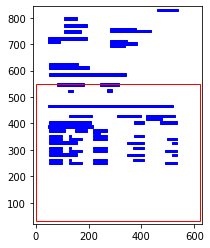

In [254]:
camelot.plot(tables[0], kind='contour').show()

In [379]:
from pandas.core.arrays.sparse import array
import pandas as pd
import numpy as np
import itertools
import re
import json

table = tables[0]
table.df

0                     1                  2              3  \
0           Ontbrek      ende aangifte(n)             Te bet     alen saldo   
1                                   *****                              0,00   
2   Deze toestand h  oudt geen rekening m  et de bedragen di  e u eventueel   
3                            Detailoverzi               cht:            Bed   
4                                                                             
5    Vorig saldo op   datum van: 30/04/20                 21                  
6   Verrichtingen e  n saldi sinds 30/04/               2021                  
7     Boekingsdatum             Onderwerp       Uitwerkings-                  
8                                                      datum                  
9        21/05/2021                     H         19/05/2021                  
10       19/05/2021             A-04.2021         20/05/2021                  
11    Toestand eind               05/2021                                     
12       22/06/2021                     H         18/06/2021                  
13       18/06/2021             A-05.2021         20/06/2021                  
14    Toestand eind               06/2021                                     
15       21/07/2021                     H         19/07/2021                  
16       19/07/2021             A-06.2021         20/07/2021                  
17     Toestand tot            31/07/2021                                     

                       4                  5            6  
0                                                         
1                                                         
2   nog aan een team inv  ordering verschul   digd bent.  
3     rag in uw voordeel    Bedrag verschul  digd aan de  
4                             FOD Financiën               
5      *****************                            0,00  
6                                                         
7                                                         
8                                                         
9              37.839,84                                  
10                                             37.839,84  
11     *****************                            0,00  
12              9.298,20                                  
13                                              9.298,20  
14     *****************                            0,00  
15             28.845,42                                  
16                                             28.845,42  
17                                                  0,00

In [380]:
import re
table = tables[0].df
full_date_regex = "^([0-9].\/){2}[0-9]{4}"
last_balance = pd.DataFrame(table.loc[table.loc[:,0].str.contains("Vorig saldo op", regex=True, case=False)])
situations_df = pd.DataFrame(table.loc[table.loc[:,0].str.contains("Toestand eind|Toestand tot", regex=True, case=False)])
details_df = pd.DataFrame(table.loc[table.loc[:,0].str.contains(full_date_regex, regex=True)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  



In [375]:
last_balance

0                    1   2      3     4              5
5  Vorig saldo op  datum van: 31/10/20  21  90,00  ****  *************

In [341]:
details_df

0          1           2          3 4          5
9   22/11/2021          H  18/11/2021   3.176,55             
10  18/11/2021  A-10.2021  20/11/2021                3.176,55
12  21/12/2021          H  17/12/2021  21.100,90             
13  17/12/2021  A-11.2021  20/12/2021               10.550,45
15  21/01/2022          H  19/01/2022   4.446,78             
16  20/01/2022  A-12.2021  20/01/2022               14.997,23

In [342]:
situations_df

0           1 2          3     4              5
11  Toestand eind     11/2021        90,00  ****  *************
14  Toestand eind     12/2021    10.640,45  ****  *************
17   Toestand tot  31/01/2022        90,00

In [381]:
details_d = {}
situations_d = {}
import numpy as np

def get_payment_values(row):
  row_value = [re.search("^[0-9]{1,4}[.,]{1,}[0-9]{1,}.?[0-9]*",value)[0] for value in row if re.search("^[0-9]{1,4}[.,]{1,}[0-9]{1,}.?[0-9]*", value) is not None][0]
  row_value_clean = float(row_value.replace(".","").replace(",","."))
  payment_entries = {}
  payment_entries["Bedrag in uw voordeel"]=0.00 if len(row)==np.where(row==row_value)[0] or len(row)==np.where(row==row_value)[0]+1 else row_value_clean
  payment_entries["Bedrag @FOD Financiën"]=row_value_clean if len(row)==np.where(row==row_value)[0] or len(row)==np.where(row==row_value)[0]+1 else 0.00
  return payment_entries

for detail in details_df.values:
  booking_date = re.search(full_date_regex,detail[0])[0]
  dict_entry = {}
  subject = detail[1] if len(detail)>4 else detail[0].split("\n")[1]
  dict_entry.update(get_payment_values(detail))
  dict_entry["Uitwerkingsdatum"] = detail[2] if re.search(full_date_regex,detail[1]) is None else re.search(full_date_regex,detail[1])[0]
  details_d[f"Boekingsdatum {booking_date} voor {subject}"] = dict_entry
details_d

for situation in situations_df.values:
  dict_entry = get_payment_values(situation)
  situation_date = [re.search("[0-9]{2}\/[0-9]{4}",value)[0] for value in situation if re.search("[0-9]{2}\/[0-9]{4}", value) is not None][0]
  situations_d[f"{situation[0]} {situation_date}"]=dict_entry

result = {}
result["Vorige balans"] = get_payment_values(last_balance.iloc[0,:])
result["Toestanden"] = situations_d
result["Detail"] = details_d


In [382]:
situations_d

{'Toestand eind 05/2021': {'Bedrag @FOD Financiën': 0.0,
  'Bedrag in uw voordeel': 0.0},
 'Toestand eind 06/2021': {'Bedrag @FOD Financiën': 0.0,
  'Bedrag in uw voordeel': 0.0},
 'Toestand tot 07/2021': {'Bedrag @FOD Financiën': 0.0,
  'Bedrag in uw voordeel': 0.0}}

In [366]:
details_d

{'Boekingsdatum 17/12/2021 voor A-11.2021': {'Bedrag @FOD Financiën': 10550.45,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '20/12/2021'},
 'Boekingsdatum 18/11/2021 voor A-10.2021': {'Bedrag @FOD Financiën': 3176.55,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '20/11/2021'},
 'Boekingsdatum 20/01/2022 voor A-12.2021': {'Bedrag @FOD Financiën': 14997.23,
  'Bedrag in uw voordeel': 0.0,
  'Uitwerkingsdatum': '20/01/2022'},
 'Boekingsdatum 21/01/2022 voor H': {'Bedrag @FOD Financiën': 0.0,
  'Bedrag in uw voordeel': 4446.78,
  'Uitwerkingsdatum': '19/01/2022'},
 'Boekingsdatum 21/12/2021 voor H': {'Bedrag @FOD Financiën': 0.0,
  'Bedrag in uw voordeel': 21100.9,
  'Uitwerkingsdatum': '17/12/2021'},
 'Boekingsdatum 22/11/2021 voor H': {'Bedrag @FOD Financiën': 0.0,
  'Bedrag in uw voordeel': 3176.55,
  'Uitwerkingsdatum': '18/11/2021'}}

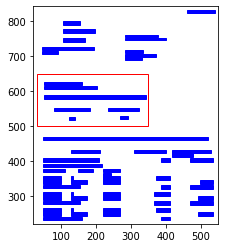

In [351]:
tables3 = camelot.read_pdf("RC_T3.pdf",flavor='stream', split_text=True, table_areas=['30,650,350,500'])
tables3
camelot.plot(tables3[0], kind='contour').show()

In [377]:
df = tables3[0].df
try:
  vat = re.findall("([0-9].+?.+)",df.iloc[0,0])[0]
  df = df.iloc[[3,4],:]
  pay_receive_string = re.search("Te betalen saldo|Terug te krijgen|Over te dragen saldo", df.iloc[0,1])[0]
  result["samenvatting"] = {"BTW-nummer":vat,
            "ontbrekende aangiftes": 0 if "*****" in df.iloc[1,0] else df.iloc[1,0],
            pay_receive_string: float(df.iloc[1,1].replace(".","").replace(",","."))}
except IndexError:
  result["samenvatting"] = {}
  document = camelot.read_pdf("RC.pdf",flavor='stream',table_areas=['30,700,650,100'])
  data = document[0].df
  vat_nr = re.search(re.compile("([0-9].+?.+)"),data.loc[data.loc[:,0].str.contains("Registratienummer")][0].values[0])[0]
  result["samenvatting"]["BTW-nummer"] = vat_nr
  amount = data.loc[data[0].str.contains("TOTAAL")].values[0]
  if re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[0]) is not None:
    result["samenvatting"]["terug te geven"] = re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[0])[0].replace(".","").replace(",",".")
  elif re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[1]) is not None:
    result["samenvatting"]["over te dragen"] = re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[1])[0].replace(".","").replace(",",".")
  elif re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[2]) is not None:
    result["samenvatting"]["te betalen"] = re.search("[0-9]?.[0-9]{0,3},[0-9]{0,2}",amount[2])[0].replace(".","").replace(",",".")

result_v = json.dumps(result)
result_v

'{"Toestanden": {"Toestand eind 11/2021": {"Bedrag in uw voordeel": 90.0, "Bedrag @FOD Financi\\u00ebn": 0.0}, "Toestand eind 12/2021": {"Bedrag in uw voordeel": 10640.45, "Bedrag @FOD Financi\\u00ebn": 0.0}, "Toestand tot 01/2022": {"Bedrag in uw voordeel": 90.0, "Bedrag @FOD Financi\\u00ebn": 0.0}}, "Detail": {"Boekingsdatum 22/11/2021 voor H": {"Bedrag in uw voordeel": 3176.55, "Bedrag @FOD Financi\\u00ebn": 0.0, "Uitwerkingsdatum": "18/11/2021"}, "Boekingsdatum 18/11/2021 voor A-10.2021": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 3176.55, "Uitwerkingsdatum": "20/11/2021"}, "Boekingsdatum 21/12/2021 voor H": {"Bedrag in uw voordeel": 21100.9, "Bedrag @FOD Financi\\u00ebn": 0.0, "Uitwerkingsdatum": "17/12/2021"}, "Boekingsdatum 17/12/2021 voor A-11.2021": {"Bedrag in uw voordeel": 0.0, "Bedrag @FOD Financi\\u00ebn": 10550.45, "Uitwerkingsdatum": "20/12/2021"}, "Boekingsdatum 21/01/2022 voor H": {"Bedrag in uw voordeel": 4446.78, "Bedrag @FOD Financi\\u00ebn": 0.0,